<a href="https://colab.research.google.com/github/yukiya06/Anime_Recommendations/blob/main/anime_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Section2 PJT : 데이터 셋을 사용하여 머신러닝 모델을 만든 후 성능 및 인사이트를 도출, 공유하는 것

#1. 데이터 선정 
* 캐글 Anime Recommendations Database
* https://www.kaggle.com/CooperUnion/anime-recommendations-database

1-1. 데이터 선정 이유
* 최근 콘텐츠 산업에서 작품 퀄리티 만큼 중요한 것이 **'추천 서비스'**이다. 대표적으로 '유튜브'와 '넷플릭스'가 많이 언급되고 있으며, 사용자들의 영상 댓글에서 손쉽게 ‘알 수 없는 알고리즘이 나를 이 영상으로 이끌었다.’, ‘나는 이 영상을 검색해서 본 것이 아니다.' 라는 내용을 만날 수 있다.
* 콘텐츠 산업 뿐만아니라 모든 커머셜 사이트에서도 고객 정보를 활용한 **맞춤형 추천 서비스**는 매출에 직결되는 만큼 중요하다.
* 이러한 트랜드에 발맞춰 애니메이션 소셜 사이트의 자료를 기반으로 머신러닝을 활용하여 **유저의 추천여부**를 예측하고, 간단한 애니메이션 추천 시스템을 만들어 보고자 한다. 

1-2. 선정한 데이터 설명
* **'애니메이션'**과 **'평가'** 데이터셋으로 나뉨
* 애니메이션:  애니메이션에 대한 설명 및 사용고객의 추천 청보로 평가를 가지고 있음
* 평가:  각 고객은 자신의 리스트에 평가를 할 수 있고, 그것이 애니메이션 점수로 표시됨
* myanimelist.net API에서 참고

1-2-1. anime 데이터
* 12,294 records under 7 attributes
* anime_id : myanimelist.net(서양권의 일본 애니메이션 주력 DB/리뷰 사이트)의 애니메이션 고유 코드
* name : 애니메이션 이름
* genre : 장르, 여러개가 들어가있으며 구분인자는 콤마
* type : 애니메이션 작품 출시방식
 * Movie : 영화관 상영 
 * TV : TV 방영
 * OVA : 오리지널 비디오(TV X, 영화관X)
 * Special : 특별판
 * Music : 뮤직 비디오
 * ONA : WEB 애니
* episodes : 애니메이션 회차 (영화는 1)
* rating : 10점 만점으로 가중 평균점수
 * Weighted Score = (v / (v + m)) * S + (m / (v + m)) * C
 * S = Average score for the anime/manga
 * v = Number users giving a score for the anime/manga
 * m = Minimum number of scored users required to get a calculated score
 * C = The mean score across the entire Anime/Manga database
* members :	해당 애니메이션 그룹의 참여 숫자 (SNS 좋아요 의미)

1-2-2. rating 데이터
* 7,813,737 records under 3 attributes
* user_id : 식별 불가한 랜덤하게 생성된 유저 아이디
* anime_id : 해당 유저가 점수 남긴 애니메이션 아이디
* rating : 10점 만점의 점수 (기록이 없으면 -1)

#2. 문제 정의
2-1. 어떤 애니메이션을 추천해야 좋을까? 어떤 애니메이션 평가가 높을까?
* 매우 복잡한 문제이므로 단순화 하여 검증을 하고자 한다. 
* **특정 애니메이션을 유저가 추천할지, 말지 (binary question)** 검증
* 유저가 추천할 애니메이션을 예측할 수 있어야 보지 않았던 애니메이션 중에서 유저에게 추천하여 좋은 평가를 받을 수 있을 것이다.

2-2. 검증 방법
* **지도학습**(supervised machine learning)모델
* **분류** (추천, 비추천) 문제로 접근하며, 작품간 유사도를 이용하여 간단한 추천 시스템을 만든다.


#3. 가설 설정
3-1.추천 여부
* 기존 feature에 없으므로, 기준을 세워 추가한다.
* **target: 유저의 추천 여부**
 * 추천 기준: [특정 애니메이션 평점 > 기존 평점 평균] 일 경우
 * 유저가 남긴 애니메이션 평점이 기존의 유저가 남겼던 평점들의 평균보다 높을 때 추천한다고 판단한다.

3-2. 추천에 영향을 미치는 특성들 검증
* 사이트에서 제공하는 애니메이션 **평점**이 높을 수록 추천을 잘 한다
* 해당 애니메이션을 좋아하는 사람이 많으면(**커뮤니티**인원多) 추천을 잘 한다
* 인기있는 **장르**의 애니메이션 추천을 잘 한다
* **평소 기대치**가 낮은 유저(평점이 후한 유저)가 추천을 잘한다
* 평소 **평가를 많이 남기는** 유저가 추천을 잘한다 



#4. 데이터 분석 (EDA, 데이터 전처리)
4-1. 데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#캐글 데이터 불러오기
anime = pd.read_csv('/content/drive/MyDrive/kaggel_anime/anime.csv')
rating = pd.read_csv('/content/drive/MyDrive/kaggel_anime/rating.csv')

In [ ]:
anime.shape, rating.shape

((12294, 7), (7813737, 3))

In [ ]:
anime.head(2)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665


In [ ]:
rating.head(2)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1


4-2. 데이터 전처리

4-2-1. 결측치 처리
* 데이터 정리 후 마지막에 한번더 결측치 처리

In [ ]:
### rating
# 기록이 없는 -1를 NaN으로 대체, 평가 수치를 평균낼때 악영향 방지
rating['rating'] = rating['rating'].apply(lambda x: np.nan if x==-1 else x)

# 결측치(평가 안한 것) 삭제
rating = rating.dropna()

4-2-2. 중복데이터 처리

In [ ]:
# 중복확인
anime.duplicated().value_counts()

False    12294
dtype: int64

In [ ]:
# 중복확인
rating.duplicated().value_counts()

False    6337240
True           1
dtype: int64

In [ ]:
# 중복된 항목만 추출
rating[rating.duplicated(keep=False)]

,user_id,anime_id,rating
4499258,42653,16498,8.0
4499316,42653,16498,8.0


In [ ]:
# 중복데이터 삭제
rating = rating.drop_duplicates(keep='first')

In [ ]:
# 삭제 확인
rating.duplicated().value_counts()

False    6337240
dtype: int64

4-2-3. 장르 리스트 정리

In [ ]:
## anime
genre_dicto = pd.DataFrame(data=anime[['anime_id','name','genre']])

# 장르 전체 이름 따로 저장 (리스트 추출)
genre_dict = pd.DataFrame(data=anime[['anime_id','name','genre']])
genre_dict.set_index('anime_id',inplace=True)
genre_dict = genre_dict.dropna() #결측치 있으면 에러남
genre_dict.head(3)

,name,genre
anime_id,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural"
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili..."
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S..."


In [ ]:
# 장르 나누기
genre_dicts = pd.DataFrame(genre_dict['genre'].str.split(',',3).tolist(), columns=['genre1','genre2','genre3','genre4'])
genre_dicts.head(3)

,genre1,genre2,genre3,genre4
0,Drama,Romance,School,Supernatural
1,Action,Adventure,Drama,"Fantasy, Magic, Military, Shounen"
2,Action,Comedy,Historical,"Parody, Samurai, Sci-Fi, Shounen"


In [ ]:
# genre 종류갯수
print(len(genre_dicts['genre1'].unique()))
print(len(genre_dicts['genre2'].unique()))
print(len(genre_dicts['genre3'].unique()))

40
43
42


In [ ]:
genre_dicts['genre1'].unique()

array(['Drama', 'Action', 'Sci-Fi', 'Comedy', 'Adventure', 'Fantasy',
       'Mystery', 'Psychological', 'Ecchi', 'Josei', 'Military',
       'Romance', 'Demons', 'Dementia', 'Music', 'Game', 'Cars', 'Mecha',
       'Horror', 'School', 'Historical', 'Kids', 'Shounen', 'Shoujo',
       'Magic', 'Harem', 'Martial Arts', 'Sports', 'Slice of Life',
       'Seinen', 'Parody', 'Police', 'Thriller', 'Supernatural',
       'Samurai', 'Super Power', 'Vampire', 'Space', 'Hentai', 'Yaoi'],
      dtype=object)

In [ ]:
#genre_dicts['genre2'].unique()
#genre_dicts['genre1'].value_counts()
#genre_dicts['genre2'].value_counts()

**Genre 1**
* 'Drama', 'Action', 'Sci-Fi: SF'
* 'Comedy', 'Adventure', 'Fantasy',
* 'Mystery', 'Psychological: 심리학', 'Ecchi:  sexual actions'
* 'Josei: 여성만화', 'Military','Romance'
* 'Demons: 괴물', 'Dementia: 망각: ', 'Music', 
* 'Game', 'Cars', 'Mecha: 메카닉', 'Horror', 'School' 
* 'Historical', 'Kids', 'Shounen: 소년', 'Shoujo: 소녀',
* 'Magic', 'Harem: 하렘', 'Martial Arts: 무예', 'Sports', 'Slice of Life: 일상물',
* 'Seinen: 청년', 'Parody: 패러디', 'Police', 'Thriller', 'Supernatural',
* 'Samurai', 'Super Power', 'Vampire', 'Space', 'Hentai', 'Yaoi'

장르가 작품 선호도에 영향을 미칠 것 같지만, 애니메이션 장르 구분이 매우 상세하고, 그 구분이 중첩되는 부분도 많으므로 더 여러개 세부항목을 나누는 것은 의미가 없어 보인다. genre표기시 가장 중요하게 생각하는 것을 상단에 표기했다고 가정하고, genre1만을 사용한다.

In [ ]:
# 가장 처음 쓴 것만 장르로 사용할 예정
anime['genre'] = anime['genre'].str.split(',').str[0]

In [ ]:
# anime_id와 name은 같은 내용이므로 하나는 제외하고 사용할 예정
anime = anime.drop('name', axis=1)

4-2-4. 데이터 타입 정리

In [ ]:
#anime.info()

In [ ]:
# episodes int로 바꾸기
anime['episodes'] = anime['episodes'].str.replace('Unknown','1')
anime['episodes']= anime['episodes'].astype(int)

In [ ]:
# 결측치 확인
anime.isnull().sum()

anime_id      0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [ ]:
# 해당 결측치가 들어있는 행 확인
anime.loc[anime['rating'].isna()].sort_values(by='members', ascending=False)

,anime_id,genre,type,episodes,rating,members
10899,25777,Action,TV,1,NaN,170054
10897,34134,Action,TV,1,NaN,90706
10976,3786,Action,Movie,1,NaN,66600
10898,30484,Sci-Fi,NaN,1,NaN,60999
10902,32937,Adventure,TV,1,NaN,54069
...,...,...,...,...,...,...
11075,34315,Kids,Movie,1,NaN,23
10983,34332,NaN,NaN,1,NaN,22
10989,34488,Comedy,TV,1,NaN,19
10990,34485,NaN,NaN,1,NaN,11


In [ ]:
# 샘플이 충분하고, 다른 데이터로 채운다 해도 유용해보이지 않으므로 삭제한다.
anime = anime.dropna()

In [ ]:
anime.shape, rating.shape

((12017, 6), (6337240, 3))

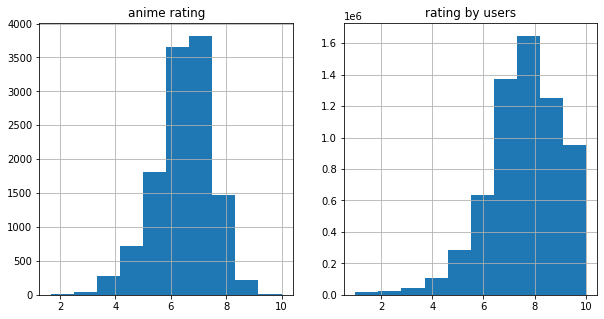

In [ ]:
# 평점 분포 확인
plt.figure(figsize=(10,5))

plt.subplot(121)
anime['rating'].hist();
plt.title('anime rating');

plt.subplot(122)
rating['rating'].hist();
plt.title('rating by users');

# y축을 빈도수(frequency)가 아니라 density로 하고 싶을 때는 density=True

4-2-5. 데이터셋 합치기
* anime 데이터에 rating 데이터를 합치고, 유저별 평가 정보를 통해 추천여부를 추가한다.

* feature engineering
 * recommendation : 평점 > 기존 평점평균 (target)

* 머신러닝 학습시 데이터 유출가능성을 감안하여 변형된 항목을 추가한다.
 * user_exp	: user_mean 을 등급화, 유저의 기대치가 어떤지 (평가에 후한편인지, 아닌지), 평가가 높으면 기대치가 낮다

 * user_review : user가 남긴 평가 갯수 추가, 참여도가 높은 고객 평가가 어떤지 (평가를 많이 남겼는지, 아닌지) 확인 필요

In [ ]:
# 유저별 평점 평균 구하기
user_mean = rating.groupby(['user_id']).mean().reset_index()
user_mean = user_mean.drop('anime_id',axis=1)
user_mean.head(3)

,user_id,rating
0,1,10.000000
1,2,10.000000
2,3,7.565217


In [ ]:
# 평가점수 평균 분포
print(user_mean['rating'].quantile(0.10))
print(user_mean['rating'].quantile(0.25))
print(user_mean['rating'].quantile(0.50))
print(user_mean['rating'].quantile(0.75))
print(user_mean['rating'].quantile(0.90))

7.15625
7.666666666666667
8.193548387096774
8.81578947368421
9.428571428571429


In [ ]:
# user_mean 6점척도 변환
# 타겟인 추천여부에 평점평균이 연관성이 높아 데이터 유출이 염려됨
# 하지만 분석에 필요한 정보이므로 변환하여 사용하고자 함
# 유저의 기대치: 평균 평점이 낮을 수록 기대치가 높다

def user_exp(x) :
  if x <= user_mean['rating'].quantile(0.10):
    return 6
  elif x <= user_mean['rating'].quantile(0.25):
    return 5
  elif x <= user_mean['rating'].quantile(0.50):
    return 4
  elif x <= user_mean['rating'].quantile(0.75):
    return 3   
  elif x <= user_mean['rating'].quantile(0.90):
    return 2   
  else :
    return 1  

In [ ]:
user_mean2 = user_mean.copy()
user_mean2['user_exp'] = user_mean2['rating'].map(user_exp)
user_mean2.head(3)
# 9분 30초

,user_id,rating,user_exp
0,1,10.000000,1
1,2,10.000000,1
2,3,7.565217,5


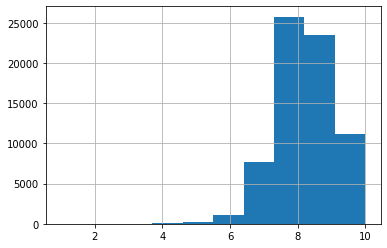

In [ ]:
# 유저별 평점 평균 분포
user_mean2['rating'].hist()

In [ ]:
a = rating.groupby('user_id')['rating'].agg('count')
user_mean2 = pd.merge(user_mean2,a, on='user_id') 
user_mean2 = user_mean2.rename(columns={'rating_x':'rating','rating_y':'user_review'})

In [ ]:
user_mean2.head(3)

,user_id,rating,user_exp,user_review
0,1,10.000000,1,4
1,2,10.000000,1,1
2,3,7.565217,5,92


In [ ]:
# 유저의 평가 횟수 분포
print(rating.groupby('user_id')['rating'].count().quantile(0.10))
print(rating.groupby('user_id')['rating'].count().quantile(0.25))
print(rating.groupby('user_id')['rating'].count().quantile(0.50))
print(rating.groupby('user_id')['rating'].count().quantile(0.75))
print(rating.groupby('user_id')['rating'].count().quantile(0.90))

3.0
13.0
45.0
114.0
230.0


In [ ]:
# 데이터 합치기
anime_total = pd.merge(anime, rating, on='anime_id', suffixes= ['', '_user'])
anime_total.reset_index(drop=True, inplace=True)

In [ ]:
anime_total2 = pd.merge(anime_total, user_mean2, on='user_id', suffixes= ['', '_mean'])

In [ ]:
# 추천여부 확인 
# 추천: 유저 평점 >= 평균 평점 (새로 생성한 feature - 타겟)
anime_total2['recommendation'] = np.where(anime_total2['rating_user']>=anime_total2['rating_mean'],True, False)

In [ ]:
anime_total2.head(3)

,anime_id,genre,type,episodes,rating,members,user_id,rating_user,rating_mean,user_exp,user_review,recommendation
0,32281,Drama,Movie,1,9.37,200630,99,5.0,5.687023,6,131,False
1,5114,Action,TV,64,9.26,793665,99,10.0,5.687023,6,131,True
2,9253,Sci-Fi,TV,24,9.17,673572,99,9.0,5.687023,6,131,True


In [ ]:
# 합친 데이터 확인 (anime_id로 검색)
condition = (anime_total2['anime_id']==22145) 
anime_total2[condition].head(3)

,anime_id,genre,type,episodes,rating,members,user_id,rating_user,rating_mean,user_exp,user_review,recommendation
4699,22145,Comedy,TV,10,8.37,122895,1031,8.0,7.696581,4,234,True
5072,22145,Comedy,TV,10,8.37,122895,1116,9.0,8.217391,3,368,True
6883,22145,Comedy,TV,10,8.37,122895,1497,8.0,6.914423,6,1040,True


In [ ]:
anime_total2.shape

(6337145, 12)

In [ ]:
# 최종세트 중복 확인
anime_total2.duplicated().value_counts()

False    6337145
dtype: int64

In [ ]:
# 타겟의 분포 확인
anime_total2['recommendation'].value_counts()

True     3381039
False    2956106
Name: recommendation, dtype: int64

In [ ]:
# 추천 비율
3381039/6337145

0.5335271640462701

타겟값의 불균형이 심하지 않으므로 보정없이 그대로 사용한다.

4-3. EDA (탐색적 데이터 분석)
* Rating과 상관관계 (members, episodes)
* 가장 인기가 많은 애니메이션 타입은?
* 가장 인기가 많은 애니메이션 장르는?
* 특정 유저가 평가를 남긴 애니메이션 목록은?
* 특정 애니메이션 평가를 남긴 이력이 있는 유저 목록은?

1) Rating과 상관관계 (members, episodes)
* 특별한 선형적 관계가 성립하지는 않는다
* 평가한 사람이 적고, 소수의 평가가 좋아서 rating이 높을 수도 있다
* 제작 편수가 많으면 member가 많은편이고, rating도 높은편이다 (확실한 선형관계X)
* member가 많으면 남겨진 평가가 많고, 비교적 rating이 높은편이다 (확실한 선형관계X)

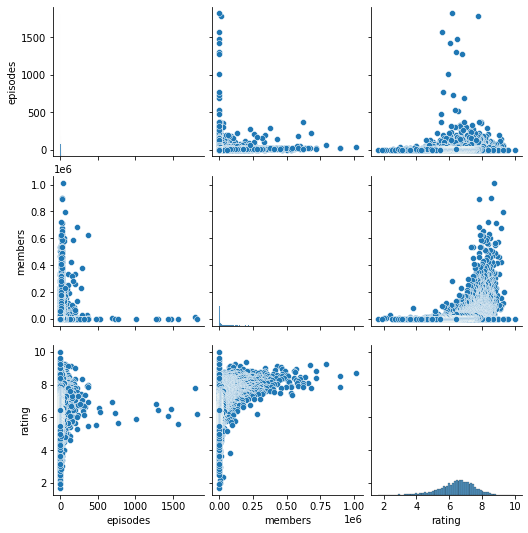

In [ ]:
sns.pairplot(anime[['episodes','members','rating']])

In [ ]:
print(anime['episodes'].quantile(0.5))
print(anime['episodes'].quantile(0.75))
print(anime['episodes'].quantile(0.95))

2.0
12.0
51.0


In [ ]:
# 에피소드 outlier(상위5%) 제거하고 관계파악
anime2 = anime.loc[anime['episodes']<51]
anime2.shape

(11395, 6)

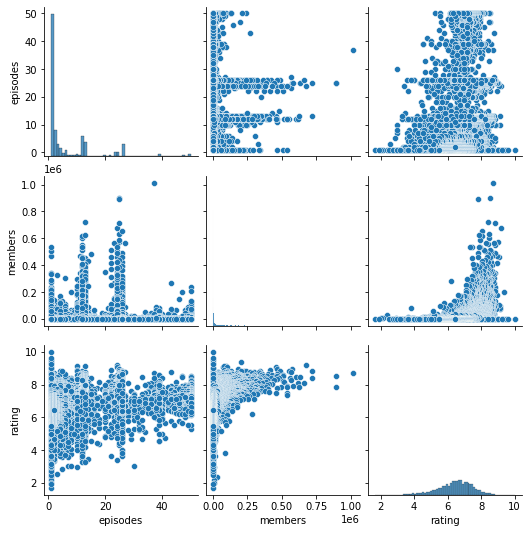

In [ ]:
# 에피소드 상위 5% 삭제후에 rating, members와의 관계 다시 보기
sns.pairplot(anime2[['episodes','members','rating']])

2) 가장 인기가 많은 애니메이션 타입 / 장르는?
* TV시리즈가 전체의 68.8%를 차지한다. 
* 액션(42.0%), 코미디(30.5%)가 전체의 72.6%를 차지한다.
* 비중의 대부분을 차지하는 타입, 장르내에서 평가를 살펴보면 전체 비중이 높은 type: Movie, TV의 평가가 높은편이며, 장르별 선호도는 drama, action이 높은편이다.

In [ ]:
columns = ['type','genre']
for col in columns:
    print(col)
    print(anime_total2[col].value_counts().head(5)/anime_total2.shape[0])
    print('=============================')

type
TV         0.688684
Movie      0.132880
OVA        0.097389
Special    0.066531
ONA        0.011380
Name: type, dtype: float64
genre
Action       0.420354
Comedy       0.305164
Adventure    0.087080
Drama        0.081003
Mystery      0.018709
Name: genre, dtype: float64


In [ ]:
df_1 = pd.DataFrame(anime_total2['type'].value_counts().head(5))
df_2 = pd.DataFrame(anime_total2['genre'].value_counts().head(6))

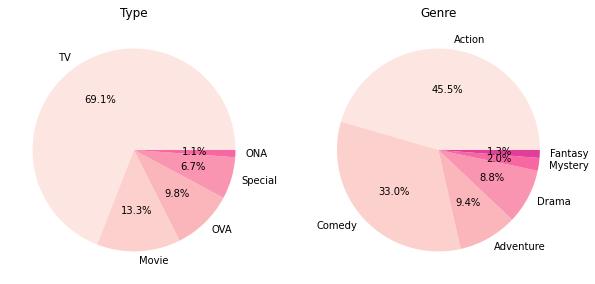

In [ ]:
colors = sns.color_palette('RdPu',9)

plt.figure(figsize=(10,5))

plt.subplot(121) 
plt.pie(df_1['type'], labels=df_1.index, autopct='%.1f%%', colors=colors);
plt.title('Type');
plt.subplot(122) 
plt.pie(df_2['genre'], labels=df_2.index, autopct='%.1f%%', colors=colors);
plt.title('Genre');

In [ ]:
anime_total2.groupby('type')['rating'].agg(['count','mean','median']).sort_values(by='mean', ascending=False)

,count,mean,median
type,,,
Movie,842078,7.832864,7.83
TV,4364293,7.753773,7.77
Special,421618,7.349545,7.36
OVA,617166,7.215986,7.31
ONA,72119,7.069045,7.22
Music,19871,7.049417,7.25


In [ ]:
anime_total2.groupby('genre')['rating'].agg(['count','mean','median']).sort_values(by='count', ascending=False).head(10)

,count,mean,median
genre,,,
Action,2663842,7.733717,7.75
Comedy,1933866,7.590202,7.61
Adventure,551839,7.703489,7.69
Drama,513330,7.810982,7.89
Mystery,118562,8.214965,8.39
Fantasy,73667,7.430798,7.61
Horror,73594,7.549927,7.88
Romance,55784,7.586161,7.71
Hentai,55357,6.510722,6.62


In [ ]:
anime_total2.groupby('genre')['rating'].agg(['count','mean','median']).sort_values(by='mean', ascending=False).head(10)

,count,mean,median
genre,,,
Josei,7348,8.469407,8.56
Sci-Fi,45572,8.389518,8.46
Psychological,14640,8.219053,8.26
Mystery,118562,8.214965,8.39
Dementia,23863,7.848917,8.23
Drama,513330,7.810982,7.89
Game,13423,7.764884,7.57
Action,2663842,7.733717,7.75
Adventure,551839,7.703489,7.69


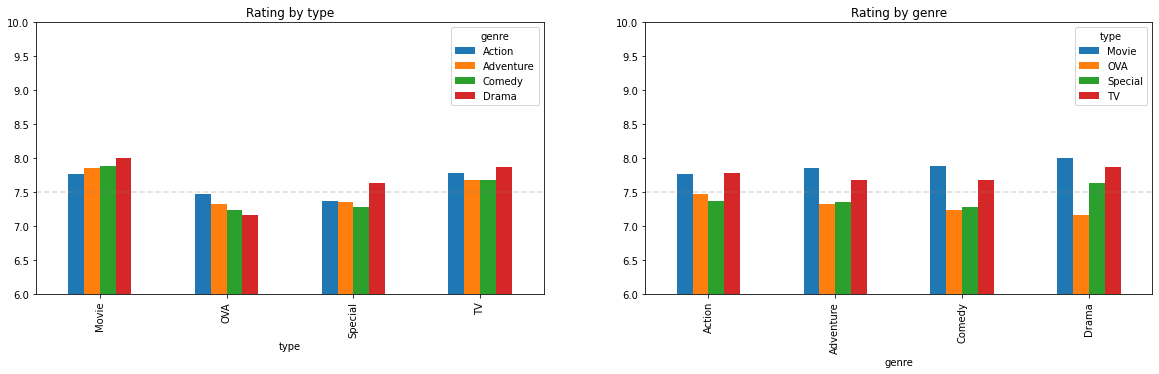

In [ ]:
cond1 = ((anime_total2['type']=='TV')|(anime_total2['type']=='Movie')|(anime_total2['type']=='OVA')|(anime_total2['type']=='Special'))&((anime_total2['genre']=='Action')|(anime_total2['genre']=='Comedy')|(anime_total2['genre']=='Adventure')|(anime_total2['genre']=='Drama'))

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].set_title('Rating by type');
axes[1].set_title('Rating by genre');

axes[0].axhline(7.5, color='gray', alpha=0.3, ls='--')
axes[1].axhline(7.5, color='gray', alpha=0.3, ls='--')

pd.pivot_table(anime_total2.loc[cond1], index='type', columns='genre', values='rating', aggfunc='mean').plot.bar(ax=axes[0], figsize=(20,5), ylim=(6,10));
pd.pivot_table(anime_total2.loc[cond1], index='genre', columns='type', values='rating', aggfunc='mean').plot.bar(ax=axes[1], figsize=(20,5), ylim=(6,10));


3) 특정 유저가 평가를 남긴 애니메이션 목록은?

In [ ]:
# 유저 아이디로 검색
#anime_total2[anime_total2['user_id']==3]

4) 특정 애니메이션 평가를 남긴 이력이 있는 유저 목록은?

In [ ]:
# 애니메이션으로 검색
#anime_total2[anime_total2['anime_id']==5114]

#5. 샘플링

In [ ]:
# 데이터가 너무 크기 때문에 10만개 수준만 검증에 사용하고자 한다
# 2%만 샘플링한다 (12만개)
6337145*0.02

126742.90000000001

In [ ]:
# 다양한 방식으로 샘플링이 가능하지만 모집단을 반영하는 랜덤샘플링으로 추출
# 샘플수를 12만, 25만 수준 비교했어도 이후 과정이 비슷하여 2%만 사용

In [ ]:
anime_s2 = anime_total2.sample(frac=0.02, random_state=6)

In [ ]:
anime_s2.shape

(126743, 12)

In [ ]:
# 샘플에서 타겟분포 확인
anime_s2['recommendation'].value_counts()

True     67672
False    59071
Name: recommendation, dtype: int64

In [ ]:
# 추천 비율
67672/126743

0.5339308679769297

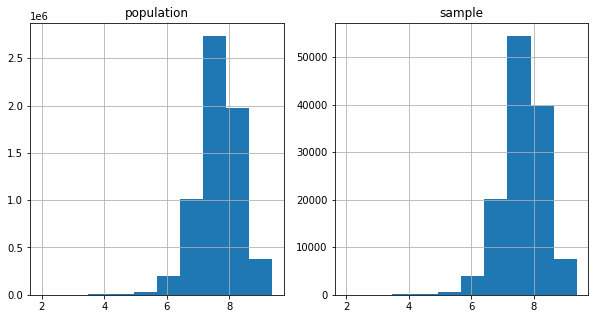

In [ ]:
# 샘플 평점 분포 확인
plt.figure(figsize=(10,5))

plt.subplot(121)
anime_total2['rating'].hist();
plt.title('population');

plt.subplot(122)
anime_s2['rating'].hist();
plt.title('sample');

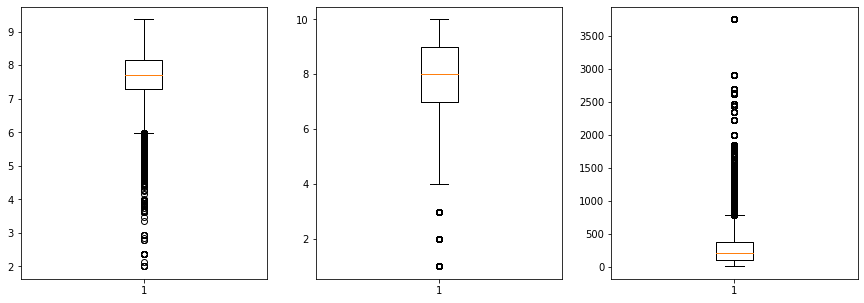

In [ ]:
# sample 2의 수치형 데이터 확인
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.boxplot(anime_s2['rating']); # 박스
plt.subplot(132)
plt.boxplot(anime_s2['rating_user']); # 박스
plt.subplot(133)
plt.boxplot(anime_s2['user_review']); # 박스

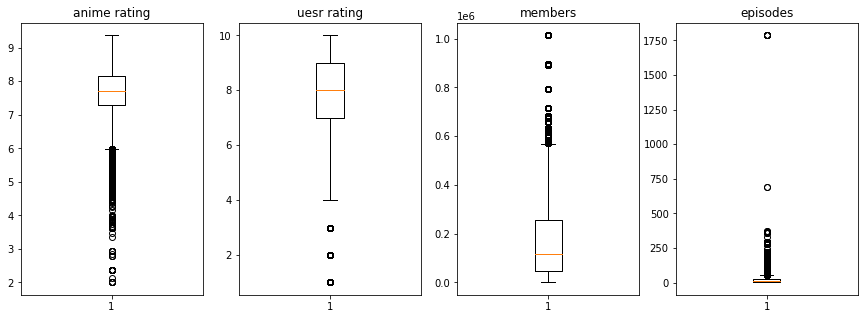

In [ ]:
# 이상치 확인 
# 샘플2 사용
plt.figure(figsize=(15,5))

plt.subplot(141)
plt.boxplot(anime_s2['rating']); # 박스
plt.title('anime rating')

plt.subplot(142)
plt.boxplot(anime_s2['rating_user']); # 박스
plt.title('uesr rating')

plt.subplot(143)
plt.boxplot(anime_s2['members']); # 박스
plt.title('members')

plt.subplot(144)
plt.boxplot(anime_s2['episodes']); # 박스
plt.title('episodes');

In [ ]:
# members 분포
print(anime_s2['members'].quantile(0.50))
print(anime_s2['members'].quantile(0.75))
print(anime_s2['members'].quantile(0.99))

116832.0
256325.0
893100.0


In [ ]:
# 에피소드 분포
print(anime_s2['episodes'].quantile(0.50))
print(anime_s2['episodes'].quantile(0.75))
print(anime_s2['episodes'].quantile(0.99))

12.0
24.0
203.0


1%에 포함되는 outlier 크기가 커서 제외한 샘플로 학습을 진행했으나 결과에 차이가 거의없어, 그대로 사용한다.

In [ ]:
# 샘플 상태 확인
anime_s2.groupby('user_id')['rating'].agg(['count','min','max','mean','median'])

,count,min,max,mean,median
user_id,,,,,
3,5,6.68,8.18,7.470000,7.520
5,12,6.75,8.56,7.455000,7.535
7,13,6.18,8.24,7.361538,7.230
11,2,7.14,8.39,7.765000,7.765
14,1,7.52,7.52,7.520000,7.520
...,...,...,...,...,...
73504,3,6.92,8.47,7.586667,7.370
73507,4,7.26,8.55,7.947500,7.990
73510,2,6.69,7.67,7.180000,7.180


In [ ]:
# genre 종류갯수
len(anime_s2['genre'].unique())

37

In [ ]:
# type 종류갯수
len(anime_s2['type'].unique())

6

#6. 훈련,검증 세트 구분

In [ ]:
anime_s2.head(3)

,anime_id,genre,type,episodes,rating,members,user_id,rating_user,rating_mean,user_exp,user_review,recommendation
392332,5525,Action,TV,25,7.41,126083,67348,6.0,7.411316,5,1573,False
1717968,2966,Adventure,TV,13,8.37,334932,28633,8.0,7.553846,5,130,True
775221,10408,Drama,Movie,1,8.61,197439,7468,9.0,8.294118,3,187,True


In [ ]:
# data leakage 예상검증 (데이터 포함하여 학습)
b_train = anime_s2['recommendation']
A_train = anime_s2.drop(['recommendation','user_exp','user_review'], axis=1)

A_train.shape, b_train.shape

((126743, 9), (126743,))

In [ ]:
# 훈련데이터를 훈련/검증 세트로
from sklearn.model_selection import train_test_split
A_train, A_test, b_train, b_test = train_test_split(A_train, b_train, train_size=0.80, test_size=0.20, random_state=6)
A_train, A_val, b_train, b_val = train_test_split(A_train, b_train, train_size=0.80, test_size=0.20, random_state=6)

A_train.shape, A_val.shape, A_test.shape, b_train.shape, b_val.shape,  b_test.shape

((81115, 9), (20279, 9), (25349, 9), (81115,), (20279,), (25349,))

In [ ]:
# 누출 예상되는 데이터 제외, 변경데이터 포함
y_train2 = anime_s2['recommendation']
X_train2 = anime_s2.drop(['recommendation','rating_user','rating_mean'], axis=1)

X_train2.shape, y_train2.shape

((126743, 9), (126743,))

In [ ]:
# 훈련데이터를 훈련/검증 세트로
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train2, y_train2, train_size=0.80, test_size=0.20, random_state=6)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, train_size=0.80, test_size=0.20, random_state=6)

X_train2.shape, X_val2.shape, X_test2.shape, y_train2.shape, y_val2.shape, y_test2.shape

((81115, 9), (20279, 9), (25349, 9), (81115,), (20279,), (25349,))

#7. 기준모델 테스트

In [ ]:
from sklearn.metrics import accuracy_score
major = b_train.mode()[0]
b_pred = [major] * len(b_train)

# 최다 클래스의 빈도가 정확도
print("training accuracy: ", accuracy_score(b_train, b_pred))

training accuracy:  0.5338716636873575


In [ ]:
major2 = y_train2.mode()[0]
y_pred2 = [major] * len(y_train2)

# 최다 클래스의 빈도가 정확도
print("training accuracy: ", accuracy_score(y_train2, y_pred2))

training accuracy:  0.5338716636873575


#8. ML 모델링, 테스트

In [ ]:
#!pip install category_encoders

In [ ]:
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

8-1. Decision trees

In [ ]:
ordinals = ['genre','type']

pipe = make_pipeline(
    OrdinalEncoder(cols=ordinals),
    StandardScaler(),
    DecisionTreeClassifier()
)

In [ ]:
pipe.fit(A_train, b_train)
print('훈련 정확도: ', pipe.score(A_train, b_train))
print('검증 정확도: ', pipe.score(A_val, b_val))

y_pred = pipe.predict(A_val)
print('검증 f1: ', f1_score(b_val, y_pred))
#1초

훈련 정확도:  1.0
검증 정확도:  0.9999506879037428
검증 f1:  0.9999538638985006


data leakage가 예상된다. (훈련, 검증이 둘다 1에 수렴) 

ating_user, rating_mean는 target과 직결되므로 삭제하고 진행한다. 

In [ ]:
pipe.fit(X_train2, y_train2)
print('훈련 정확도: ', pipe.score(X_train2, y_train2))
print('검증 정확도: ', pipe.score(X_val2, y_val2))

y_pred2 = pipe.predict(X_val2)
print('검증 f1: ', f1_score(y_val2, y_pred2))
#1초

훈련 정확도:  1.0
검증 정확도:  0.5796143794072686
검증 f1:  0.6086038290252973


8-2. 앙상블 (Random forest)

In [ ]:
ordinals = ['genre','type']

pipe = make_pipeline(
    OrdinalEncoder(cols=ordinals),
    RobustScaler(),
    RandomForestClassifier(n_jobs=-1, random_state=6, oob_score=True)
)

In [ ]:
pipe.named_steps

{'ordinalencoder': OrdinalEncoder(cols=['genre', 'type']),
 'randomforestclassifier': RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=6),
 'robustscaler': RobustScaler()}

In [ ]:
pipe.fit(A_train, b_train)
print('훈련 정확도: ', pipe.score(A_train, b_train))
print('검증 정확도: ', pipe.score(A_val, b_val))

b_pred = pipe.predict(A_val)
print('검증 f1: ', f1_score(b_val, b_pred))
# data leakage 확인

훈련 정확도:  1.0
검증 정확도:  0.9995068790374279
검증 f1:  0.9995384899390807


data leakage가 예상된다. (훈련, 검증이 둘다 1에 수렴) 

ating_user, rating_mean는 target과 직결되므로 삭제하고 진행한다. 

In [ ]:
pipe.fit(X_train2, y_train2)
print('훈련 정확도: ', pipe.score(X_train2, y_train2))
print('검증 정확도: ', pipe.score(X_val2, y_val2))

y_pred2 = pipe.predict(X_val2)
print('검증 f1: ', f1_score(y_val2, y_pred2))
#20초
#이 데이터로 사용 

훈련 정확도:  1.0
검증 정확도:  0.6401696336111248
검증 f1:  0.6655360498693679


* tree 모델보다 앙상블(ramdom forest)모델의 성능이 뛰어난 결과가 나왔다.
* 과적합되어 검증시 모델성능이 너무 낮다. 하이퍼파라미터 튜닝을 통한 개선이 필요하다.
* 이전 테스트에서 전체 샘플수가 많아진다고 해서 조건이 동일모델의 성능에서 큰 영향을 주진 않았다. 12만 샘플 그대로 사용한다.
* feature를 추가한 샘플2가 f1스코어가 높다. 이후부터는 추가한 샘플2 상태로 사용한다.

다양한 평가지표 해석

In [ ]:
from sklearn.metrics import classification_report
pipe.fit(X_train2, y_train2)
print(classification_report(y_val2, pipe.predict(X_val2)))

              precision    recall  f1-score   support

       False       0.62      0.61      0.61      9441
        True       0.66      0.67      0.67     10838

    accuracy                           0.64     20279
   macro avg       0.64      0.64      0.64     20279
weighted avg       0.64      0.64      0.64     20279



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


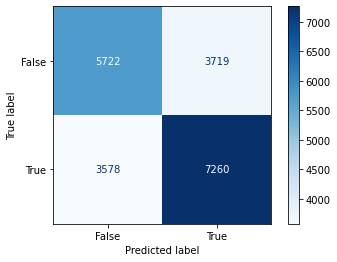

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val2, y_val2,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

y_pred_proba = pipe.predict_proba(X_val2)[:, -1]
print('AUC score: ', roc_auc_score(y_val2, y_pred_proba))

AUC score:  0.6887301061228954


Text(0, 0.5, 'TPR')

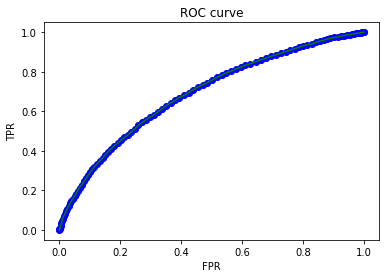

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val2, y_pred_proba)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

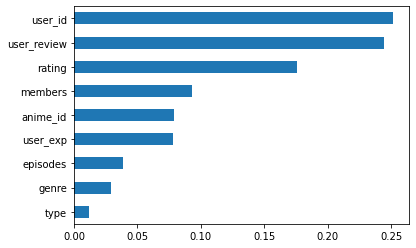

In [ ]:
# feature_importance
# named_steps으로 특성 중요도 확인
enc = pipe.named_steps['ordinalencoder']
encoded_columns = enc.transform(X_val2).columns

model_dt = pipe.named_steps['randomforestclassifier']

importances = pd.Series(model_dt.feature_importances_, encoded_columns)
importances.sort_values().plot.barh();

전체 rating보다도 user_id와 user_review 수가 영향이 제일 크다.
두항목은 유저별로 부여되는 수치로 카디널리티가 높기때문에 permutation importance도 함께 고려해야한다 (하단)

In [ ]:
#!pip install eli5

In [ ]:
# permutation importance
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.pipeline import Pipeline

# pipeline 다시 정의
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(cols=ordinals), RobustScaler())),
    ('rf', RandomForestClassifier(min_samples_split=89, max_depth=10, class_weight={1: 1.5, 0: 1}, random_state=6, n_jobs=-1)) 
], verbose=1)

pipe.fit(X_train2, y_train2);


# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps['rf'], # model, 그냥 pipe.named_steps['xgbclassifier'],ok
    scoring='f1', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=6
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val2new = pipe.named_steps['preprocessing'].transform(X_val2)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val2new, y_val2);

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing rf, total=   7.1s


In [ ]:
feature_names = X_train2.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0834 ± 0.0026,rating
0.0080 ± 0.0012,user_exp
0.0013 ± 0.0011,user_review
-0.0000 ± 0.0002,type
-0.0001 ± 0.0008,anime_id
-0.0002 ± 0.0007,user_id
-0.0006 ± 0.0007,genre
-0.0012 ± 0.0005,episodes
-0.0018 ± 0.0010,members


feature importance를 구했을때는  user_id와 user_review의 영향이 크게 나왔고, 3위에 rating 영향이 있었으나, permutation importance를 구하니 rating이 1위로 나왔다. 위의 2항목은 개별 유저별로 표시가 되어 카디널리티가 높아 그 영향도가 높게 나왔던 것으로 보이며, 이를 제외했을때는 결국 작품 점수가 가장 큰 영향을 미친다. 유저가 기존에 평가한 리뷰수나 그 점수와 관련된 항목은 영향력이 매우 적게 나왔다. 

하이퍼파라미터 튜닝

In [ ]:
# RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler

ordinals = ['genre','type']
pipe = make_pipeline(
    OrdinalEncoder(cols=ordinals),
    RobustScaler(),
    RandomForestClassifier(n_jobs=-1, random_state=6, oob_score=True)    
) #순서중요

dists = {
    'randomforestclassifier__max_depth': [10,15],
    'randomforestclassifier__min_samples_split': range(50,100),
    'randomforestclassifier__class_weight':['balanced', {1:1.5, 0:1}, {1:1.2,0:1}] 
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train2, y_train2)
#18분

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['genre',
                                                                   'type'])),
                                             ('robustscaler', RobustScaler()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     oob_score=True,
                                                                     random_state=6))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'randomforestclassifier__class_weight': ['balanced',
                                                                                 {0: 1,
                                                                                  1: 1.5},
                                       

In [ ]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('f1: ', clf.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__min_samples_split': 87, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__class_weight': {1: 1.5, 0: 1}}
f1:  0.7205890702357044


In [ ]:
model = clf.best_estimator_

8-3. 앙상블 (Boosting)

8-3-1. AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
ordinals = ['genre','type']

pipe = make_pipeline(
    OrdinalEncoder(cols=ordinals),
    RobustScaler(),
    AdaBoostClassifier(random_state=6)
)

In [ ]:
pipe.fit(X_train2, y_train2)
print('훈련 정확도: ', pipe.score(X_train2, y_train2))
print('검증 정확도: ', pipe.score(X_val2, y_val2))

y_pred2 = pipe.predict(X_val2)
print('검증 f1: ', f1_score(y_val2, y_pred2))
#20초
#이 데이터로 사용 

훈련 정확도:  0.6662516180731061
검증 정확도:  0.6634942551407861
검증 f1:  0.6844830774921399


8-3-2. XGBoost

In [ ]:
#!pip install xgboost

In [ ]:
from xgboost import XGBClassifier

pipe = make_pipeline(
    OrdinalEncoder(cols=ordinals),
    RobustScaler(),
    XGBClassifier(n_estimators=150
                  , random_state=6
                  , n_jobs=-1
                  , max_depth=5
                  , learning_rate=0.2
                 )
)

pipe.fit(X_train2, y_train2);
#10초

In [ ]:
y_pred2 = pipe.predict(X_val2)
print('검증 정확도: ', accuracy_score(y_val2, y_pred2))
print('검증 f1: ', f1_score(y_val2, y_pred2))

print(classification_report(y_val2, y_pred2))

검증 정확도:  0.6681789042852212
검증 f1:  0.694926780613864
              precision    recall  f1-score   support

       False       0.65      0.62      0.64      9441
        True       0.68      0.71      0.69     10838

    accuracy                           0.67     20279
   macro avg       0.67      0.67      0.67     20279
weighted avg       0.67      0.67      0.67     20279



In [ ]:
encoder = OrdinalEncoder(cols=ordinals)
X_train_encoded = encoder.fit_transform(X_train2) # 학습데이터
X_val_encoded = encoder.transform(X_val2) # 검증데이터

model = XGBClassifier(
    n_estimators=1000,  # <= 1000 트리로 설정했지만, early stopping 에 따라 조절됩니다.
    max_depth=7,        # default=3, high cardinality 특성을 위해 기본보다 높여 보았습니다.
    learning_rate=0.2, # scale_pos_weight=ratio, # imbalance 데이터 일 경우 비율을 적용합니다.
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train2), 
            (X_val_encoded, y_val2)]

model.fit(X_train_encoded, y_train2, 
          eval_set=eval_set,
          eval_metric='error', # #(wrong cases)/#(all cases)
          early_stopping_rounds=50
         ) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

[0]	validation_0-error:0.330272	validation_1-error:0.338675
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.329766	validation_1-error:0.336752
[2]	validation_0-error:0.328681	validation_1-error:0.336407
[3]	validation_0-error:0.328755	validation_1-error:0.335421
[4]	validation_0-error:0.327905	validation_1-error:0.335174
[5]	validation_0-error:0.327868	validation_1-error:0.335224
[6]	validation_0-error:0.327165	validation_1-error:0.335273
[7]	validation_0-error:0.326043	validation_1-error:0.335224
[8]	validation_0-error:0.324601	validation_1-error:0.33404
[9]	validation_0-error:0.323787	validation_1-error:0.334385
[10]	validation_0-error:0.323134	validation_1-error:0.333646
[11]	validation_0-error:0.32248	validation_1-error:0.333202
[12]	validation_0-error:0.322024	validation_1-error:0.333744
[13]	validation_0-error:0.321309	validation_1-error:0.3345

XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=1000, n_jobs=-1)

In [ ]:
print('검증 정확도', model.score(X_val_encoded, y_val2))
print(classification_report(y_val2, model.predict(X_val_encoded)))

검증 정확도 0.6670940381675625
              precision    recall  f1-score   support

       False       0.65      0.62      0.63      9441
        True       0.68      0.71      0.70     10838

    accuracy                           0.67     20279
   macro avg       0.67      0.66      0.66     20279
weighted avg       0.67      0.67      0.67     20279



기본모델은 boosting이 randomforest보다 성능이 높게 나왔으나, 하이퍼파라미터 조정후 성능이 randomforest가 더 높아 최종적으로 rf모델을 사용하고자 한다. boosting은 하이퍼파라미터에 민감하게 반응하는데 적정한 조정이 어려워서 성능개선이 많이 되지 않은 것 같다.

#9. 최종모델 점검

In [ ]:
X_train2.shape, X_val2.shape, X_test2.shape 

((81115, 9), (20279, 9), (25349, 9))

In [ ]:
y_train2.shape, y_val2.shape, y_test2.shape 

((81115,), (20279,), (25349,))

In [ ]:
# train, val 데이터 합쳐서 전체 train set으로 사용
X_train2sum = pd.concat([X_train2, X_val2], axis=0)
y_train2sum = pd.concat([y_train2, y_val2], axis=0)

In [ ]:
X_train2sum.shape, y_train2sum.shape

((101394, 9), (101394,))

In [ ]:
# class weights 계산
# n_samples / (n_classes * np.bincount(y))
custom = len(y_train2sum)/(2*np.bincount(y_train2sum))
custom

array([1.07292967, 0.93635373])

In [ ]:
ordinals = ['genre','type']

pipe = make_pipeline(
    OrdinalEncoder(cols=ordinals),
    RobustScaler(),
    RandomForestClassifier(n_jobs=-1, random_state=6, oob_score=True, min_samples_split=89, max_depth=10, class_weight={1: 1.6, 0: 1})
)

pipe.fit(X_train2sum, y_train2sum)
print('훈련 정확도: ', pipe.score(X_train2sum, y_train2sum))

y_pred2 = pipe.predict(X_test2)
print('test f1: ', f1_score(y_test2, y_pred2))

print(classification_report(y_test2, y_pred2))
# 13초

훈련 정확도:  0.651350178511549
test f1:  0.7210069656605158
              precision    recall  f1-score   support

       False       0.72      0.37      0.49     11820
        True       0.61      0.87      0.72     13529

    accuracy                           0.64     25349
   macro avg       0.67      0.62      0.61     25349
weighted avg       0.66      0.64      0.61     25349



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


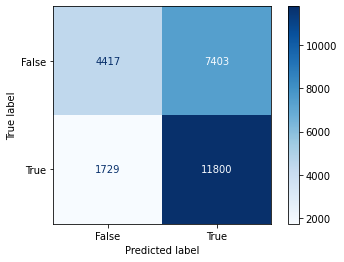

In [ ]:
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_test2, y_test2,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.show()

하이퍼파라미터 튜닝을 하며 True에 가중치를 주어서 FN(2형에러)는 감소하였으나 FP(1형 에러)는 증가하였다.

In [ ]:
from sklearn.metrics import roc_auc_score

y_pred_proba = pipe.predict_proba(X_val2)[:, -1]
print('AUC score: ', roc_auc_score(y_val2, y_pred_proba))

AUC score:  0.7455627043911899


Text(0, 0.5, 'TPR')

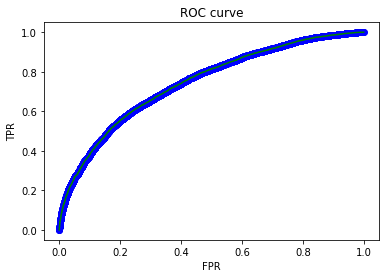

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val2, y_pred_proba)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

#10. ML 모델 해석

10-1. PDP
* 개별 특성이 타겟에 어떻게 작용하는지 설명

In [ ]:
#!pip install pdpbox

In [ ]:
ordinals = ['genre','type']

pipe = make_pipeline(
    OrdinalEncoder(cols=ordinals),
    RobustScaler(),
    RandomForestClassifier(n_jobs=-1, random_state=6, oob_score=True, min_samples_split=89, max_depth=10, class_weight={1: 1.6, 0: 1})
)

pipe.fit(X_train2, y_train2)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['genre', 'type'],
                                mapping=[{'col': 'genre',
                                          'data_type': dtype('O'),
                                          'mapping': Action            1
Adventure         2
Comedy            3
Drama             4
Fantasy           5
Mystery           6
Harem             7
Music             8
Horror            9
Mecha            10
Sci-Fi           11
Romance          12
Magic            13
Ecchi            14
Dementia         15
School           16
Military         17
Shounen          18
Psychological    19
Hentai           20
Josei            21
Game             22
Demons           23
Shoujo           24
Kids             25
Historical       26
Sports           27
Slic...
Yaoi             32
Thriller         33
Supernatural     34
Vampire          35
Martial Arts     36
NaN              -2
dtype: int64},
                                         {'col':

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


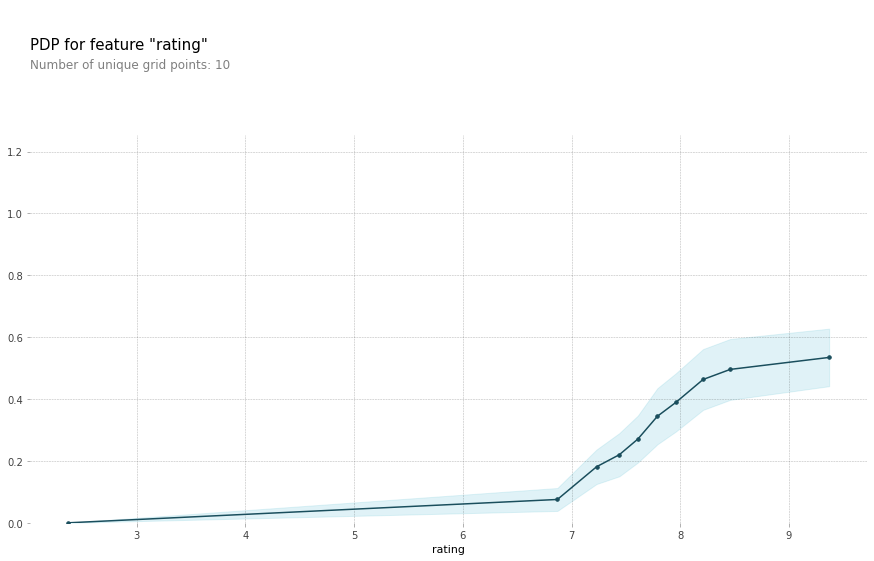

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'rating'

isolated = pdp_isolate(
    model=pipe, 
    dataset=X_val2, 
    model_features=X_val2.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

평가가 7점 미만에서는 영향도가 낮지만, 그 이상에서는 영향도가 높다 (기울기 가파름)

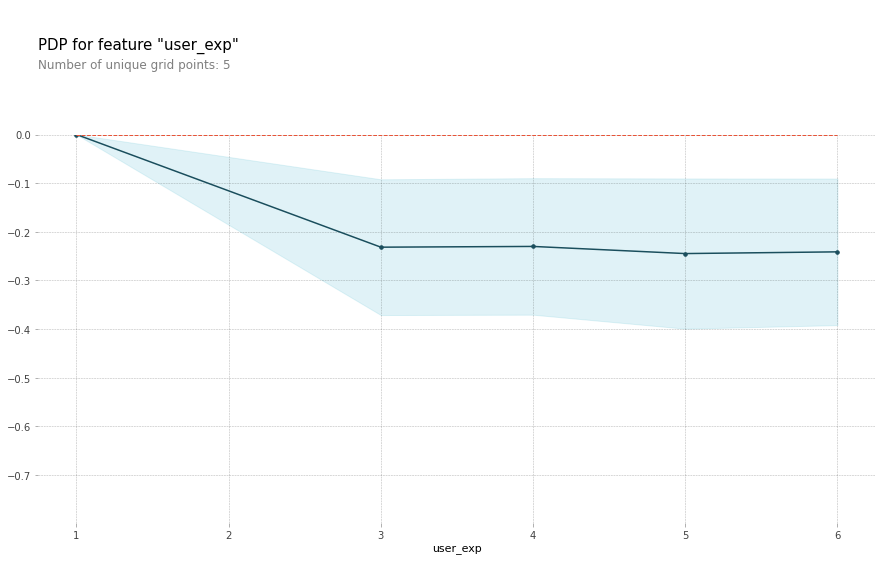

In [ ]:
feature = 'user_exp'

isolated = pdp_isolate(
    model=pipe, 
    dataset=X_val2, 
    model_features=X_val2.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

기대와 추천여부가 음의 상관관계가 있으나, 기대정도가 3이상이면 영향이 거의 없다.

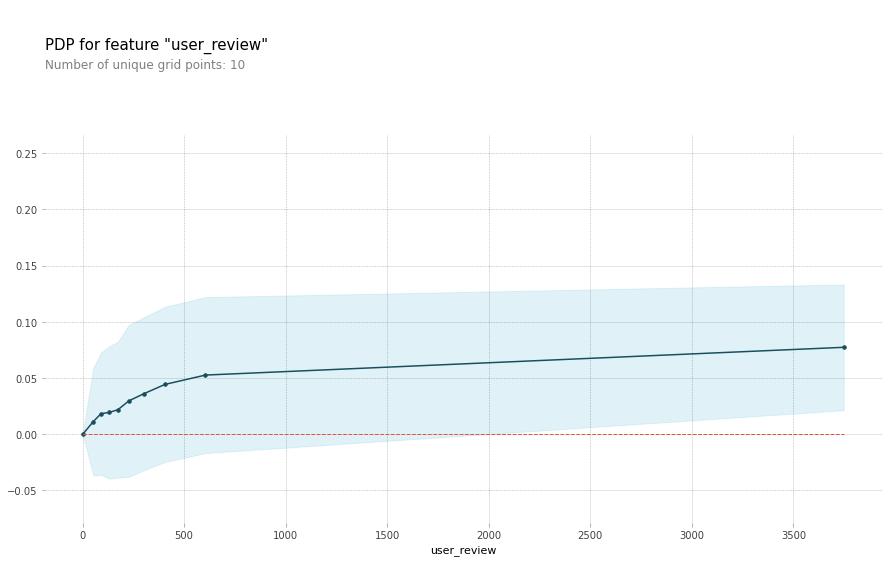

In [ ]:
feature = 'user_review'

isolated = pdp_isolate(
    model=pipe, 
    dataset=X_val2, 
    model_features=X_val2.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

리뷰수가 500개 미만에서는 참여도가 높으면 추천확률이 높아지지만 그 이후에는 영향도가 낮다.

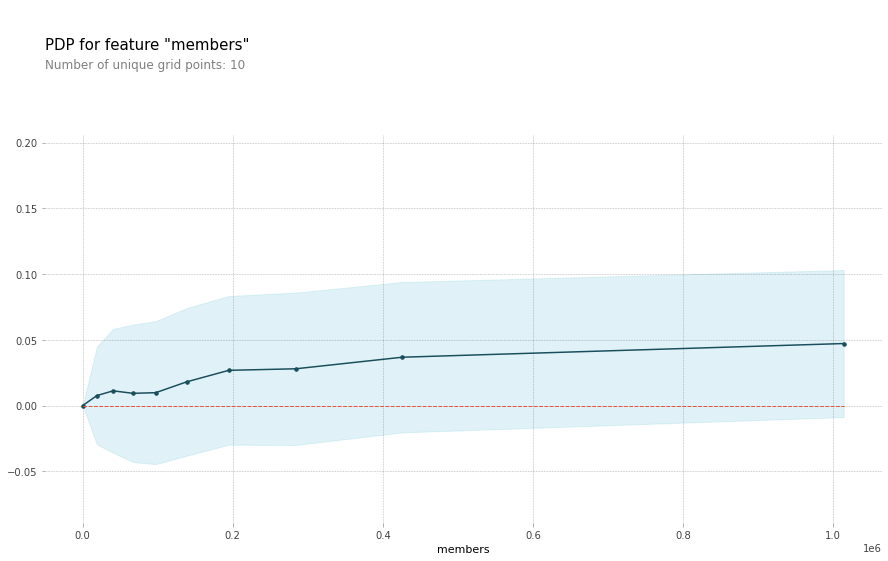

In [ ]:
feature = 'members'

isolated = pdp_isolate(
    model=pipe, 
    dataset=X_val2, 
    model_features=X_val2.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

초반에 멤버수가 적을때는 영향이 있지만, 금방 편차가 적어지며 영향력이 거의 없어진다.

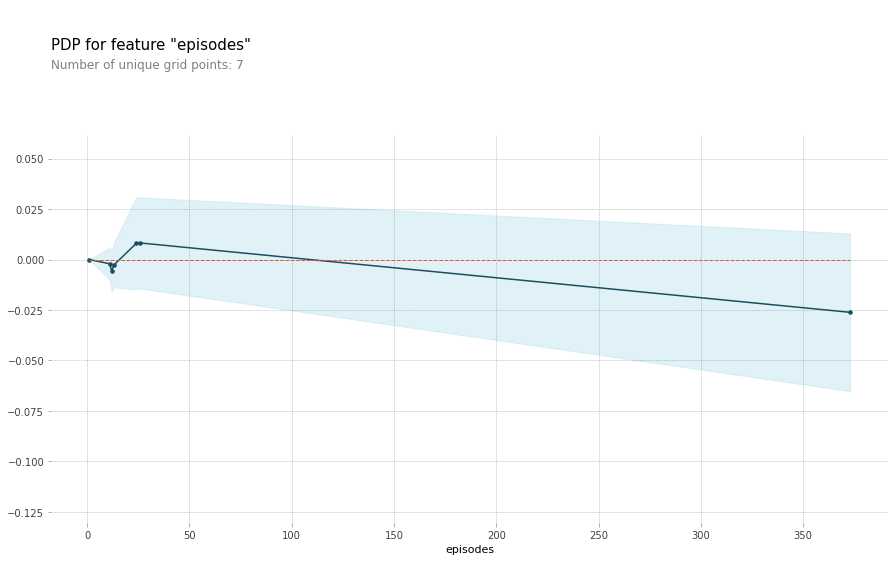

In [ ]:
feature = 'episodes'

isolated = pdp_isolate(
    model=pipe, 
    dataset=X_val2, 
    model_features=X_val2.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

에피소드가 25개 미만일때는 편수가 증가하면 추천확률이 올라가지만, 그 이후에는 점점 하락하며, 너무 편수가 늘어지면 오히려 추천확률이 낮아진다.

10-2. SHAP
* 특정 작품에 대한 추천여부 예상, 사유 검증

In [ ]:
#!pip install shap

In [ ]:
# 모델 세팅
# 1) 인코더
encoder = OrdinalEncoder(cols=ordinals)
X_train_encoded = encoder.fit_transform(X_train2) # 학습데이터
X_val_encoded = encoder.transform(X_val2) # 검증데이터


In [ ]:
# 2) ML모델
rf_model = RandomForestClassifier(min_samples_split=89, max_depth=10, class_weight={1: 1.5, 0: 1}, random_state=6, n_jobs=-1)
rf_model.fit(X_train_encoded,y_train2)

RandomForestClassifier(class_weight={0: 1, 1: 1.5}, max_depth=10,
                       min_samples_split=89, n_jobs=-1, random_state=6)

특정 데이터 예측 확인 (anime_id, user_id로 검색)

In [ ]:
# anime 이름으로 anime_id 찾기
genre_dicto[genre_dicto['name']=='Naruto']

,anime_id,name,genre
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P..."


In [ ]:
X_val2[X_val2['anime_id']==20][:1]

,anime_id,genre,type,episodes,rating,members,user_id,user_exp,user_review
6167512,20,Action,TV,220,7.81,683297,64654,4,24


In [ ]:
# data for prediction
search = (X_val_encoded['anime_id']==20) & (X_val_encoded['user_id']==64654)
row = X_val_encoded.loc[search]
row

,anime_id,genre,type,episodes,rating,members,user_id,user_exp,user_review
6167512,20,1.0,1,220,7.81,683297,64654,4,24


In [ ]:
# 실제 값
y_val2.loc[search]

6167512    False
Name: recommendation, dtype: bool

In [ ]:
# 모델 예측값
rf_model.predict(row)

array([ True])

In [ ]:
#!pip install shap

In [ ]:
import shap

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1],
    features=row
)
# first array: a negative outcome
# second array: the positive outcome

테스트 샘플에 대한 각 특성들의 영향

In [ ]:
# 100개 테스트 샘플에 대해서 각 특성들의 영향
shap.initjs()
shap_values = explainer.shap_values(X_val_encoded.iloc[:100])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_val_encoded.iloc[:100])

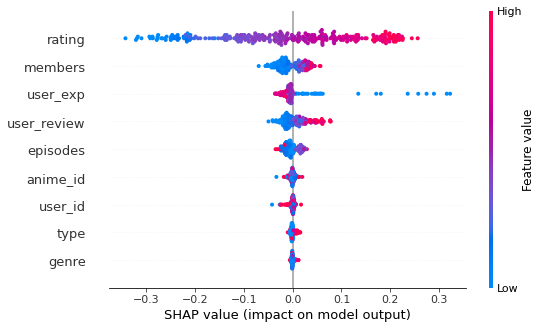

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(X_val_encoded.iloc[:300])
shap.summary_plot(shap_values[1], X_val_encoded.iloc[:300])

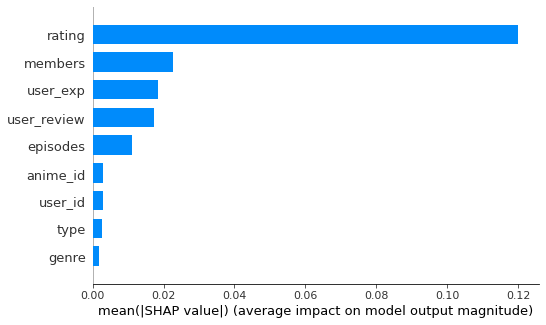

In [ ]:
shap.initjs()
shap.summary_plot(shap_values[1], X_val_encoded.iloc[:300], plot_type="bar")

#11. 추천 시스템

Cosine Similarity 
유사도를 이용한 추천 시스템 적용

코사인 유사도는 두 벡터 간의 코사인 각도를 이용하여 구할 수 있는 두 벡터의 유사도를 의미한다. 두 벡터의 방향이 완전히 동일한 경우에는 1의 값을 가지며, 90°의 각을 이루면 0, 180°로 반대의 방향을 가지면 -1의 값을 갖게 된다. 즉, 결국 코사인 유사도는 -1 이상 1 이하의 값을 가지며 값이 1에 가까울수록 유사도가 높다고 판단할 수 있다.

In [ ]:
# 데이터 합치기
df = pd.merge(rating, genre_dicto[['anime_id','name']], on='anime_id').drop('anime_id',axis=1)
df.head(3)

,user_id,rating,name
0,1,10.0,Highschool of the Dead
1,3,6.0,Highschool of the Dead
2,5,2.0,Highschool of the Dead


In [ ]:
# 애니메이션 평가
count_rating = df.groupby("name")["rating"].count().sort_values(ascending = False)
count_rating

name
Death Note                         34226
Sword Art Online                   26310
Shingeki no Kyojin                 25289
Code Geass: Hangyaku no Lelouch    24126
Angel Beats!                       23565
                                   ...  
Ashita no Eleventachi                  1
Ashita e Mukau Hito                    1
Shounen Ninja Kaze no Fujimaru         1
Hi no Tori: Hagoromo-hen               1
Mechakko Dotakon                       1
Name: rating, Length: 9926, dtype: int64

In [ ]:
df.groupby("name")["rating"].count().quantile(0.90)

1689.0

In [ ]:
# 평가 너무 적은것은 제외시키기, 기준보다 큰 것만 
r = 1689
more_than_r_ratings = count_rating[count_rating.apply(lambda x: x >= r)].index
df_r = df[df['name'].apply(lambda x: x in more_than_r_ratings)]

In [ ]:
df_recom = df_r.pivot_table(index='user_id',columns='name',values='rating')
df_recom.iloc[3:8,3:8]

name,11eyes,A-Channel,Aa! Megami-sama! (TV),Aa! Megami-sama!: Sorezore no Tsubasa,Absolute Duo
user_id,,,,,
5,NaN,NaN,NaN,NaN,2.0
7,NaN,NaN,NaN,NaN,8.0
8,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN


In [ ]:
import scipy as sp

In [ ]:
# Value normalization
df_recomnew = df_recom.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)

# Filling Nan values as 0
df_recomnew.fillna(0, inplace=True)

# Transposing
df_recomnew = df_recomnew.T

# Dropping columns with the values of 0 (unrated)
df_recomnew = df_recomnew.loc[:, (df_recomnew != 0).any(axis=0)]

# Using scipy package to convert to sparse matrix format for the similarity computation.
piv_sparse = sp.sparse.csr_matrix(df_recomnew.values)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#model based on anime similarity
anime_similarity = cosine_similarity(piv_sparse)

#Df of anime similarities
ani_sim_df = pd.DataFrame(anime_similarity, index = df_recomnew.index, columns = df_recomnew.index)

In [ ]:
def anime_recommendation(ani_name):
    #5개추천
    number = 1
    print('Recommended because you watched {}:\n'.format(ani_name))
    for anime in ani_sim_df.sort_values(by = ani_name, ascending = False).index[1:6]:
        print(f'#{number}: {anime}, {round(ani_sim_df[anime][ani_name]*100,2)}% match')
        number +=1 

애니메이션 제목을 넣으면 유사도가 높은 순서대로 5개의 작품 추천

In [ ]:
anime_recommendation('Naruto')

Recommended because you watched Naruto:

#1: Bleach, 11.9% match
#2: Naruto: Shippuuden Movie 1, 8.89% match
#3: Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!, 8.75% match
#4: Naruto: Shippuuden Movie 2 - Kizuna, 7.07% match
#5: Dragon Ball GT, 6.78% match


In [ ]:
anime_recommendation('Death Note')

Recommended because you watched Death Note:

#1: Code Geass: Hangyaku no Lelouch R2, 30.62% match
#2: Code Geass: Hangyaku no Lelouch, 29.7% match
#3: Fullmetal Alchemist: Brotherhood, 27.16% match
#4: Steins;Gate, 23.84% match
#5: Shingeki no Kyojin, 22.17% match
